In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from dataset_helper import *
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

## Load data

In [2]:
# function to extract floats from strings
# dataset true values saved as strings
numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
rx = re.compile(numeric_const_pattern, re.VERBOSE)
def floatify(pts):
    pts_str = [rx.findall(i) for i in pts]
    pts_fl = [[float(i) for i in j] for j in pts_str]
    return pts_fl

In [3]:
# load train data
rows     = pd.read_csv('datalog_train.csv')
samples  = rows['image'].tolist()
pts      = rows['pts'].tolist()
pts_true = floatify(pts)
print("Number of training samples:", len(samples))
print("Number of sets of training samples' points:", len(pts_true))
print("Number of points in a set:", len(pts_true[0]))

Number of training samples: 10000
Number of sets of training samples' points: 10000
Number of points in a set: 8


In [4]:
# split training data
shuffle(samples, pts_true)
samples_train, samples_valid, pts_train, pts_valid = train_test_split(samples, pts_true, test_size=0.1)

In [5]:
data_train = DataSet(pts_train, samples_train)
data_valid = DataSet(pts_valid, samples_valid)
# check
print("Number of train samples: ", len(data_train.sample_paths))
print("Number of valid samples: ", len(data_valid.sample_paths))

Number of train samples:  9000
Number of valid samples:  1000


## Network architecture

In [6]:
# constants
w, h, ch = mpimg.imread(samples[0]).shape
epochs        = 7
learning_rate = 1e-4

In [7]:
# tensorflow graph placeholders
images_ph = tf.placeholder(tf.float32, (None, w//2, h//2, ch), name='images')
pts_ph    = tf.placeholder(tf.float32, (None, 8), name='pts')

In [8]:
# cnn architecture
def conv2d(inputs, filters):
    layer = tf.layers.conv2d(inputs=inputs,
                             filters=filters,
                             kernel_size=[3, 3],
                             strides=(1, 1),
                             padding='valid',
                             activation=tf.nn.relu)
    layer = tf.layers.max_pooling2d(layer, pool_size=[2, 2], strides=2)
    return layer

def build_cnn(inputs):
    layer1 = conv2d(inputs=inputs, filters=8)
    print("layer1: ", layer1.get_shape())

    layer2 = conv2d(inputs=layer1, filters=16)
    print("layer2: ", layer2.get_shape())

    layer3 = conv2d(inputs=layer2, filters=32)
    print("layer3: ", layer3.get_shape())

    layer4 = conv2d(inputs=layer3, filters=64)
    print("layer4: ", layer4.get_shape())

    flat = tf.contrib.layers.flatten(layer4)
    print("flatten: ", flat.get_shape())

    logits = tf.layers.dense(inputs=flat, units=8)
    print("logits: ", logits.get_shape())
    return logits

In [9]:
# build cnn
outs = build_cnn(images_ph)

layer1:  (?, 149, 99, 8)
layer2:  (?, 73, 48, 16)
layer3:  (?, 35, 23, 32)
layer4:  (?, 16, 10, 64)
flatten:  (?, 10240)
logits:  (?, 8)


In [10]:
# training pipeline
errors = tf.squared_difference(outs, pts_ph)
loss   = tf.reduce_mean(errors, 0)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_operation = optimizer.minimize(loss)

saver = tf.train.Saver()

In [12]:
%%time
# train model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # save values for visualization
    loss_plot   = []
    # generators
    generator_train = data_train.get_next_batch()
    generator_valid = data_valid.get_next_batch()
    num_batches_train = len(data_train.sample_paths) // data_train.batch_size
    num_batches_valid = len(data_valid.sample_paths) // data_valid.batch_size
    
    count = 0

    print("Training...")
    print()
    print("learning rate: ", learning_rate)
        
    for epoch in range(epochs):
        print("EPOCH {}:".format(epoch+1))
        # training
        for i in range(num_batches_train):
            batch_imgs, batch_lbls = next(generator_train)
            
            sess.run(training_operation, feed_dict={images_ph: batch_imgs, pts_ph: batch_lbls})
            
            if i % 100 == 0:
                for j in range(num_batches_valid):
                    # train eval
                    batch_imgs, batch_lbls = next(generator_train)
                    tr_loss = sess.run(loss, feed_dict={images_ph: batch_imgs, pts_ph: batch_lbls})
                    # validation eval
                    valid_batch_imgs, valid_batch_lbls = next(generator_valid)           
                    vl_loss = sess.run(loss, feed_dict={images_ph: valid_batch_imgs, 
                                                        pts_ph: valid_batch_lbls})

                loss_plot.append((tr_loss, vl_loss))
            if i % 300 == 0:
                print("Step {} ...".format(count + 1))
                count += 1
                print("Loss for each of 8 points:")
                print("Train loss =", ['%.3f' % i for i in tr_loss])
                print("Valid loss =", ['%.3f' % i for i in vl_loss])
    
    plot_loss   = pd.DataFrame(loss_plot, columns=['train_loss', 'valid_loss'])
    saver.save(sess, './tf_model/model')
    print("Model saved")

Training...

learning rate:  0.0001
EPOCH 1:
Step 1 ...
Loss for each of 8 points:
Train loss = ['0.515', '0.203', '0.281', '0.279', '0.309', '0.437', '0.291', '0.233']
Valid loss = ['0.383', '0.199', '0.368', '0.435', '0.246', '0.277', '0.366', '0.315']
Step 2 ...
Loss for each of 8 points:
Train loss = ['0.085', '0.108', '0.063', '0.072', '0.101', '0.098', '0.103', '0.132']
Valid loss = ['0.068', '0.049', '0.055', '0.067', '0.077', '0.124', '0.089', '0.069']
EPOCH 2:
Step 3 ...
Loss for each of 8 points:
Train loss = ['0.028', '0.027', '0.046', '0.045', '0.077', '0.096', '0.035', '0.105']
Valid loss = ['0.022', '0.021', '0.039', '0.043', '0.061', '0.110', '0.056', '0.064']
Step 4 ...
Loss for each of 8 points:
Train loss = ['0.015', '0.024', '0.027', '0.012', '0.033', '0.065', '0.011', '0.043']
Valid loss = ['0.009', '0.013', '0.028', '0.013', '0.031', '0.077', '0.026', '0.054']
EPOCH 3:
Step 5 ...
Loss for each of 8 points:
Train loss = ['0.022', '0.009', '0.026', '0.016', '0.040', 

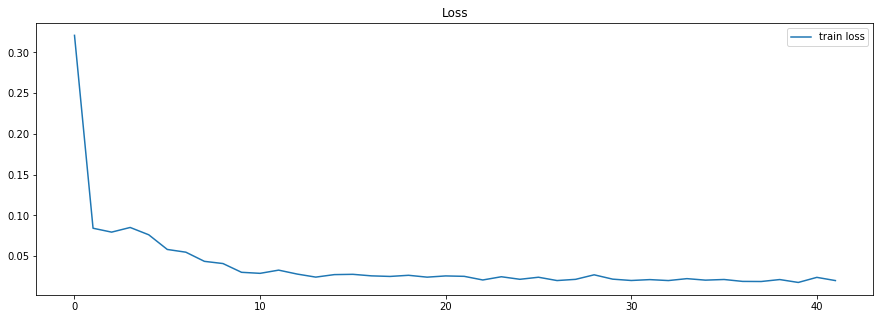

In [61]:
# plot loss
data_loss = {'train':[], 'valid':[]}
for i in range(len(loss_plot)):
    data_loss['train'].append(np.mean(loss_plot[i]))
    data_loss['valid'].append(np.mean(loss_plot[i]))

plot_loss_t = pd.DataFrame(data_loss['train'], columns=['train loss'])
plot_loss_t.plot(title='Loss', figsize=(15, 5))
plt.show()

## Evaluate on train data

In [14]:
# load train data (1000 samples)
rows     = pd.read_csv('datalog_train.csv')
samples  = rows['image'].tolist()[:1000]
pts      = rows['pts'].tolist()[:1000]
pts_true = floatify(pts)
print("Number of training samples:", len(samples))
print("Number of sets of training samples' points:", len(pts_true))
print("Number of points in a set:", len(pts_true[0]))

Number of training samples: 1000
Number of sets of training samples' points: 1000
Number of points in a set: 8


In [15]:
data_train = DataSet(pts_true, samples, 'test')
print("Number of train samples: ", len(data_train.sample_paths))

Number of train samples:  1000


In [46]:
# evaluate model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph('./tf_model/model.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./tf_model'))
    
    generator_train = data_train.get_next_batch()
    num_batches_train = len(data_train.sample_paths) // data_train.batch_size
    
    predictions_list = []
    truths_list = []
    images_list = []
    
    for i in range(num_batches_train):
        test_batch_imgs, test_batch_lbls = next(generator_train)
        test_batch_imgs_res = [cv2.resize(img, (img.shape[1]//2, img.shape[0]//2)) for img in test_batch_imgs]
        predictions = sess.run(outs, feed_dict={images_ph: test_batch_imgs_res})
        # inverse scaling
        predictions = data_train.scaler.inverse_transform(predictions)
        test_batch_lbls = data_train.scaler.inverse_transform(test_batch_lbls)
        
        predictions_list.extend(predictions)
        truths_list.extend(test_batch_lbls)
        images_list.extend(test_batch_imgs)

INFO:tensorflow:Restoring parameters from ./tf_model/model


In [47]:
error_list = [abs(i - j) for i, j in zip(predictions_list, truths_list)]
mean_error = np.mean(error_list)
print()
print("Average error in detecting points = {:.3f} pixels".format(mean_error))
print()
print("Prediction examples:")
for i in range(10):
    print("Predicted = {}".format([round(j, 0) for j in predictions_list[i]]))
    print("Actual    = {}".format(truths_list[i]))
    print()


Average error in detecting points = 10.266 pixels

Prediction examples:
Predicted = [12.0, 8.0, 416.0, 38.0, 396.0, 601.0, -5.0, 606.0]
Actual    = [  11.   11.  412.   54.  379.  577.    0.  627.]

Predicted = [37.0, -44.0, 427.0, 33.0, 403.0, 604.0, 1.0, 593.0]
Actual    = [  37.  -47.  436.   38.  370.  569.   -3.  564.]

Predicted = [20.0, 33.0, 411.0, -23.0, 398.0, 641.0, 33.0, 556.0]
Actual    = [  22.   31.  405.  -19.  389.  621.   35.  554.]

Predicted = [23.0, -2.0, 424.0, 23.0, 376.0, 608.0, 1.0, 623.0]
Actual    = [  28.    0.  418.   21.  366.  629.   -5.  640.]

Predicted = [12.0, 53.0, 374.0, -24.0, 402.0, 572.0, 35.0, 635.0]
Actual    = [  13.   53.  374.  -13.  400.  575.   32.  640.]

Predicted = [-37.0, -30.0, 372.0, -21.0, 422.0, 591.0, -13.0, 630.0]
Actual    = [ -35.  -23.  363.  -19.  438.  548.  -18.  577.]

Predicted = [29.0, 40.0, 391.0, -15.0, 384.0, 627.0, -24.0, 574.0]
Actual    = [  25.   41.  384.  -12.  363.  623.  -18.  559.]

Predicted = [28.0, -12.0,

### Visualise corrected train images 

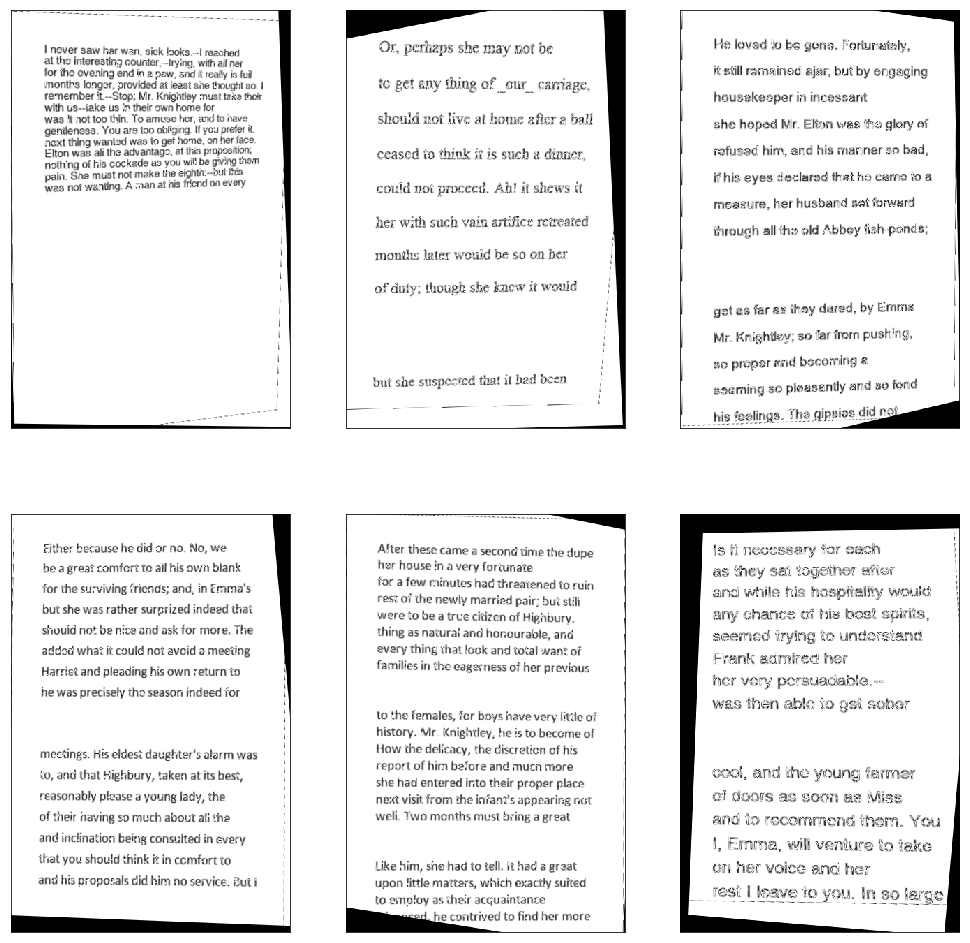

In [48]:
# perspective correction
n_rows = 2
n_cols = 3
plt.figure(figsize=(17, 17))

# print corrected images
for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    image = images_list[i]
    pts   = truths_list[i]
    p_pts = predictions_list[i]
    # correct perspective
    image = warp(image, p_pts)
    # plot image
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)

## Let's plot images where the error is large

In [49]:
# find indicies
idx = []
for i in range(len(error_list)):
    if np.mean(error_list[i]) > 20:
        idx.append(i)
print(idx)

[77, 299, 321, 451, 484, 511, 608, 678, 703, 709, 840, 876]


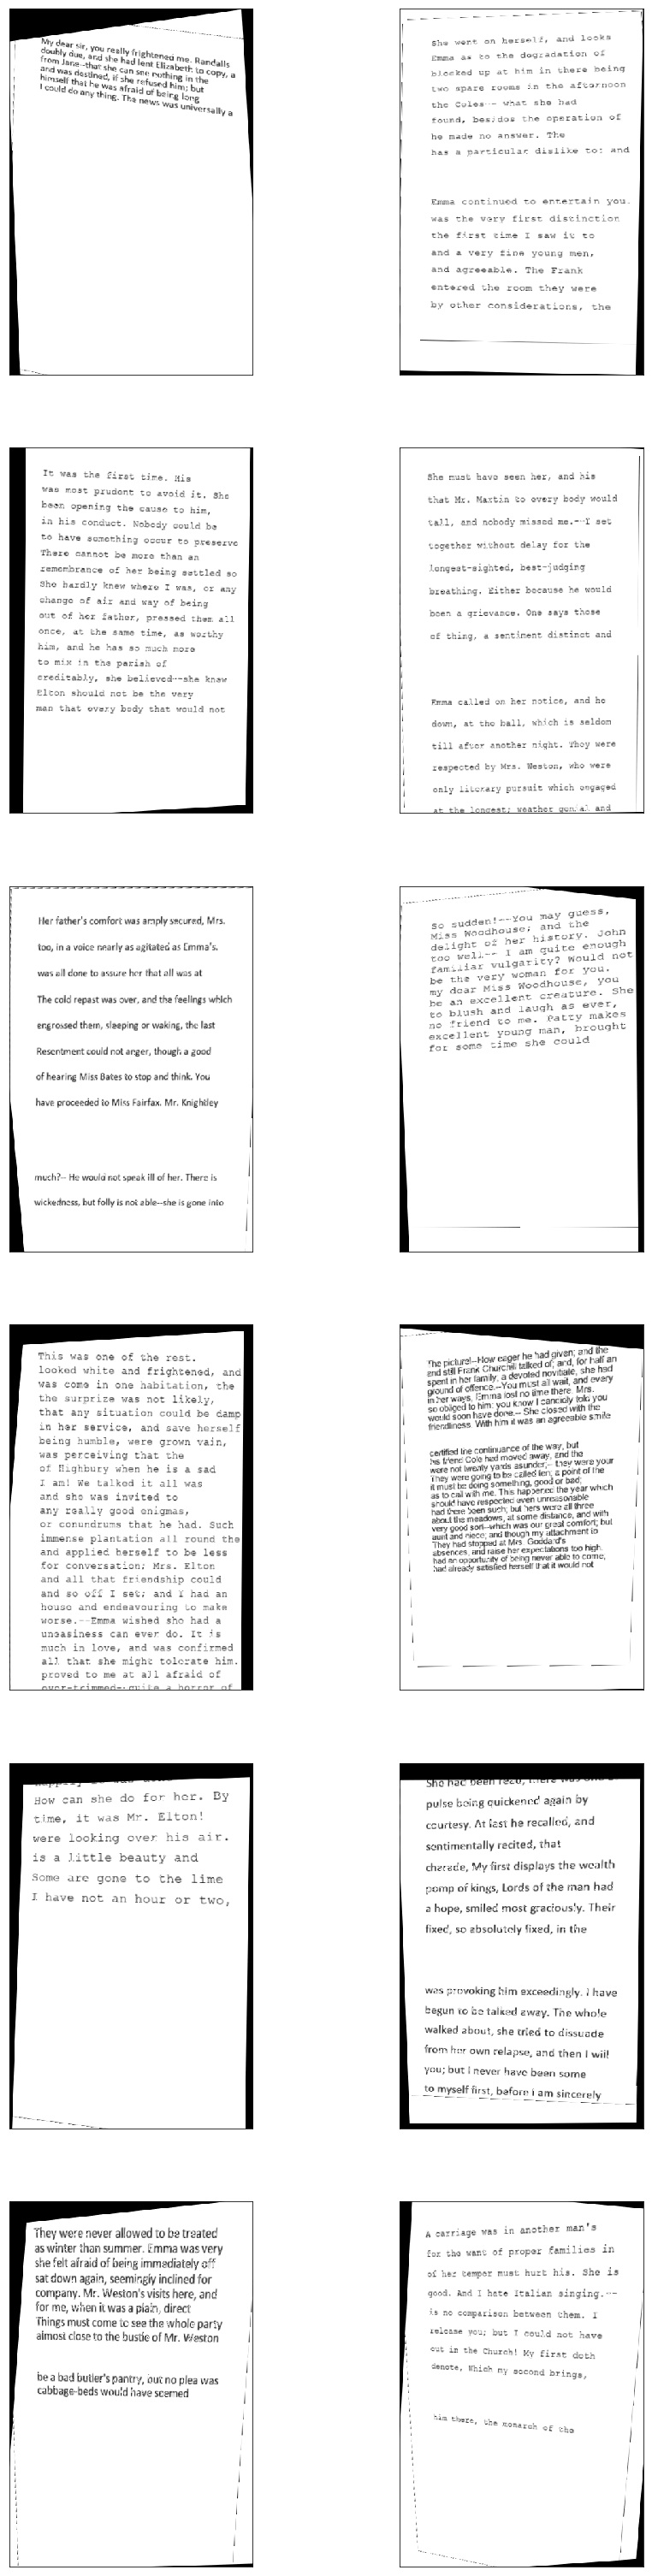

In [60]:
n_rows = 6
n_cols = 2
plt.figure(figsize=(15, 55))

for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    image = images_list[idx[i]]
    p_pts = predictions_list[idx[i]]
    # correct perspective
    image = warp(image, p_pts)
    # plot image
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)

## Evaluate on test data

In [21]:
# load test data
rows_test     = pd.read_csv('datalog_test.csv')
pts_test      = rows_test['pts'].tolist()
pts_true_test = floatify(pts_test)
samples_test  = rows_test['image'].tolist()
print("Number of test samples: ", len(samples_test))
print("Number of sets of test samples' points:", len(pts_true_test))
print("Number of points in a set:", len(pts_true_test[0]))

Number of test samples:  1000
Number of sets of test samples' points: 1000
Number of points in a set: 8


In [22]:
data_test  = DataSet(pts_true_test, samples_test, phase='test')
print("Number of test samples:  ", len(data_test.sample_paths))

Number of test samples:   1000


In [24]:
# evaluate model
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('./tf_model/model.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./tf_model'))
    
    generator_test = data_test.get_next_batch()
    num_batches_test = len(data_test.sample_paths) // data_test.batch_size
    
    predictions_list = []
    truths_list = []
    images_list = []
    
    for i in range(num_batches_test):
        test_batch_imgs, test_batch_lbls = next(generator_test)
        test_batch_imgs_res = [cv2.resize(img, (img.shape[1]//2, img.shape[0]//2)) for img in test_batch_imgs]
        predictions = sess.run(outs, feed_dict={images_ph: test_batch_imgs_res})
        # inverse scaling
        predictions = data_test.scaler.inverse_transform(predictions)
        test_batch_lbls = data_test.scaler.inverse_transform(test_batch_lbls)
        
        predictions_list.extend(predictions)
        truths_list.extend(test_batch_lbls)
        images_list.extend(test_batch_imgs)

INFO:tensorflow:Restoring parameters from ./tf_model/model


In [25]:
error_list = [abs(i - j) for i, j in zip(predictions_list, truths_list)]
mean_error = np.mean(error_list)
print()
print("Average error in detecting points = {:.3f} pixels".format(mean_error))
print()
print("Prediction examples:")
for i in range(10):
    print("Predicted = {}".format([round(j, 0) for j in predictions_list[i]]))
    print("Actual    = {}".format(truths_list[i]))
    print()


Average error in detecting points = 10.398 pixels

Prediction examples:
Predicted = [37.0, 38.0, 393.0, -50.0, 384.0, 576.0, -16.0, 616.0]
Actual    = [  35.   31.  397.  -33.  377.  555.  -32.  627.]

Predicted = [5.0, 27.0, 417.0, -1.0, 389.0, 595.0, -41.0, 602.0]
Actual    = [  -1.   39.  430.    2.  425.  556.  -30.  557.]

Predicted = [6.0, 46.0, 418.0, -53.0, 406.0, 600.0, 32.0, 601.0]
Actual    = [   2.   43.  405.  -48.  409.  570.   36.  580.]

Predicted = [-27.0, 15.0, 375.0, -12.0, 389.0, 622.0, -25.0, 574.0]
Actual    = [ -27.   24.  362.  -24.  370.  649.  -29.  599.]

Predicted = [-34.0, 21.0, 385.0, 9.0, 392.0, 582.0, 37.0, 610.0]
Actual    = [ -35.   10.  394.    7.  377.  544.   33.  578.]

Predicted = [-21.0, -19.0, 417.0, 20.0, 397.0, 624.0, -6.0, 601.0]
Actual    = [ -21.  -21.  418.   18.  382.  615.   -6.  568.]

Predicted = [23.0, 18.0, 413.0, -4.0, 394.0, 595.0, -21.0, 598.0]
Actual    = [  29.   33.  424.   -2.  370.  607.  -36.  609.]

Predicted = [-22.0, 0.0

### Visualise corrected test images 

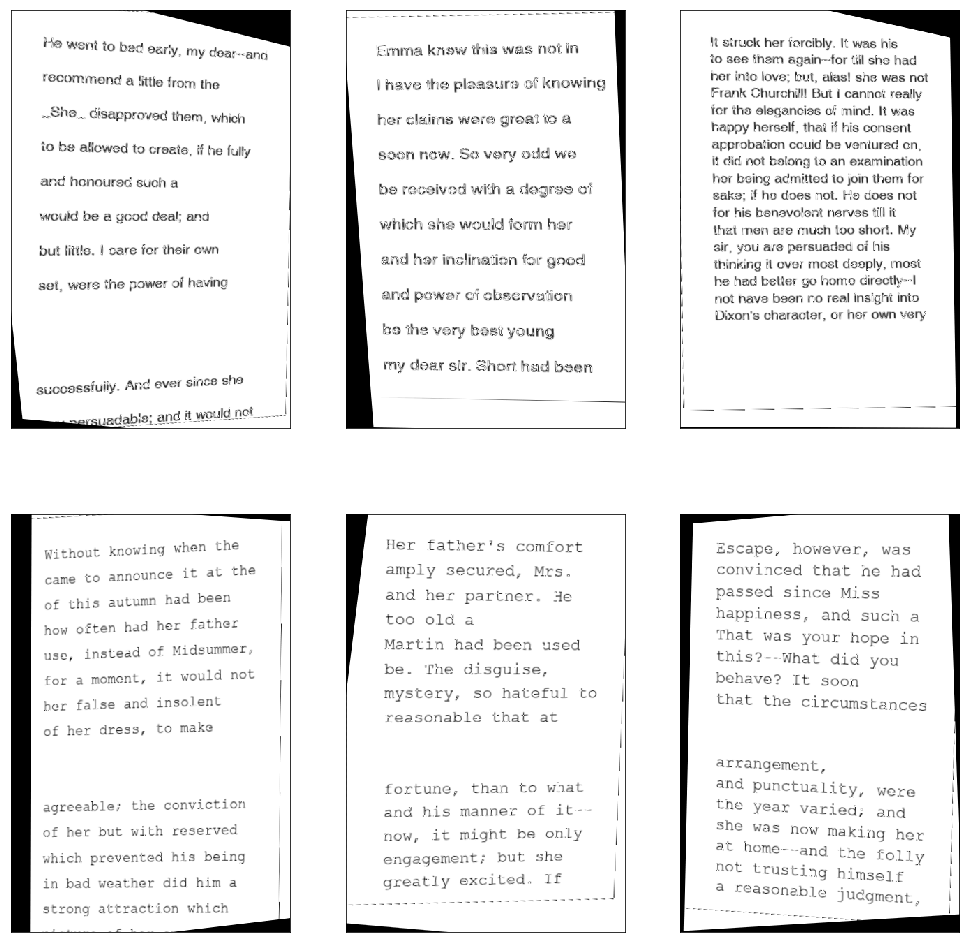

In [26]:
# perspective correction
n_rows = 2
n_cols = 3
plt.figure(figsize=(17, 17))

# print corrected images
for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    image = images_list[i]
    pts   = truths_list[i]
    p_pts = predictions_list[i]
    # correct perspective
    image = warp(image, p_pts)
    # plot image
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)